In [1]:
import numpy as np
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Load the dataset
import pickle

import numpy as np
import matplotlib.pyplot as plt
import random

import scipy.sparse as sp
 
import pickle
from scipy.sparse import csr_matrix

from scipy.sparse import eye
from scipy.sparse.linalg import inv
 

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from data_loader import *

from RelaxRegularizeAPPR import *
import time

In [2]:

dataset_list = ['political-blog', 'citeseer', 'cora', 'mnist-tr-nei10',
                'pubmed', 'blogcatalog', 'youtube', 'ogbn-arxiv']



dataset_list = ['political-blog', 'citeseer', 'cora', 'blogcatalog',  'mnist-tr-nei10', 'pubmed']
dataset_list = ['political-blog', 'citeseer', 'cora']

    


In [3]:
# Solve without coarsening, for baseline results


beta = 0.25 

for dataset in dataset_list:
    
    
    adj_matrix, labels = load_graph_data(dataset)
    if not isinstance(adj_matrix, csr_matrix):
        adj_matrix = csr_matrix(adj_matrix_orig)   
        adj_matrix.eliminate_zeros()       
    n = len(labels)
    num_classes = max(labels)+1
    degree_vector = np.asarray(adj_matrix.sum(axis=1)).flatten()
    Theta,nTheta, Y_onehot =  prepare_small_problems(adj_matrix,labels)
            
    for epsilon in [ 0.001,0.0001,0.00001]:
        
    

        print(dataset,epsilon)
        try:
            out_relax = pickle.load(open('regret_appr/%s_beta%f_runrelax_epsilon%f.pkl' % (dataset,beta, epsilon),'rb'))
            out_reg = pickle.load(open('regret_appr/%s_beta%f_runreg_epsilon%f.pkl' % (dataset,beta, epsilon),'rb'))
        except:


            T= beta * nTheta + (1. - beta) * eye(n)
            sigma = ( Y_onehot.T @ (T @ Y_onehot)).diagonal().sum()
            Delta = num_classes
            
            num_ops = [0]
            start = time.time()
            out_relax =  Relaxation_APPR(adj_matrix,degree_vector,epsilon, beta, sigma, Delta, Y_onehot,num_ops, maxneighbors = None, maxiter = None)
            runtime = time.time() - start
            
            Y_pred = out_relax['y_pred']
            q = out_relax['q']
            misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))
            out_relax['misclass'] = misclass
            out_relax['Delta'] = Delta
            out_relax['sigma'] = sigma
            out_relax['runtime'] = runtime
            out_relax['num_ops'] = num_ops[0]
            
            
            num_ops = [0]
            start = time.time()
            out_reg = Regularize_APPR(adj_matrix,degree_vector,epsilon, beta, sigma,  Y_onehot, num_ops,maxneighbors = None, maxiter = None)
            runtime = time.time() - start
            
            Y_pred = out_reg['y_pred']
            q = out_reg['q']
            misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))
            out_reg['misclass'] = misclass
            out_reg['sigma'] = sigma
            out_reg['runtime'] = runtime
            out_reg['num_ops'] = num_ops[0]
 

            pickle.dump(out_relax, open('regret_appr/%s_beta%f_runrelax_epsilon%f.pkl' % (dataset,beta, epsilon),'wb'))
            pickle.dump(out_reg, open('regret_appr/%s_beta%f_runreg_epsilon%f.pkl' % (dataset,beta, epsilon),'wb'))

        print(dataset, out_relax['misclass'], out_reg['misclass'])


political-blog 0.001


C:\Users\yifan\Dropbox\Projects\randomized_graph_learning\experiments\RelaxRegularizeAPPR.py:108: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  g = get_loss_grad(psi, q, Y[t, :])


political-blog 0.4067103109656301 0.4132569558101473
political-blog 0.0001
political-blog 0.1955810147299509 0.16121112929623568
political-blog 1e-05
political-blog 0.1546644844517185 0.07283142389525368
citeseer 0.001
citeseer 0.44976303317535543 0.318957345971564
citeseer 0.0001
citeseer 0.3881516587677725 0.2957345971563981
citeseer 1e-05
citeseer 0.3635071090047393 0.2895734597156398
cora 0.001
cora 0.3963782696177062 0.24104627766599598
cora 0.0001
cora 0.28209255533199196 0.18953722334004025
cora 1e-05
cora 0.24748490945674045 0.18591549295774648


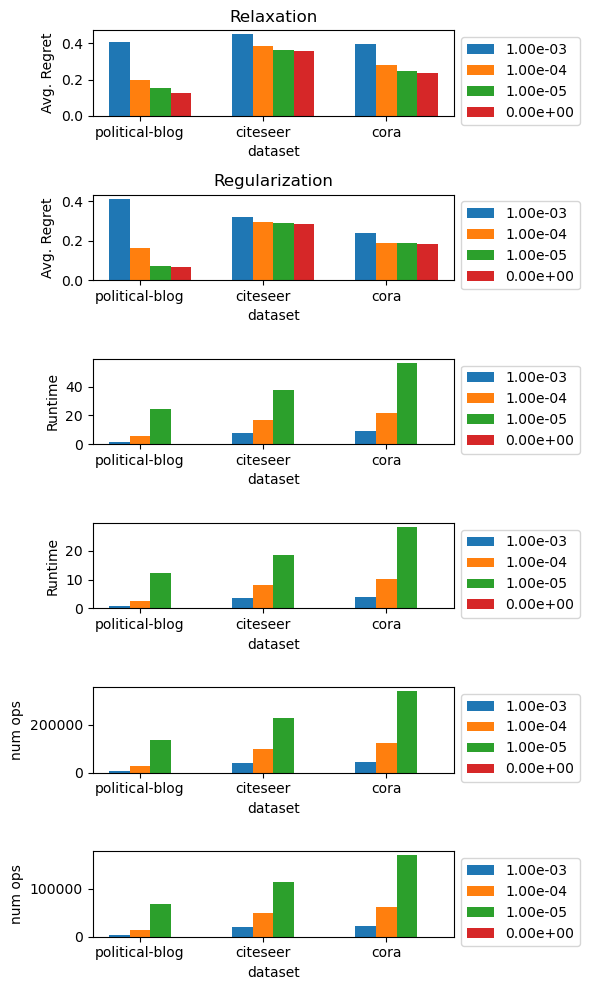

In [15]:


dataset_list = ['political-blog', 'citeseer', 'cora']#, 'blogcatalog',  'mnist-tr-nei10']
epsilon_list =   [0.001,0.0001,0.00001,0]

misclass = np.zeros((6, len(dataset_list), len(epsilon_list)))  # 3D array to hold misclassification data


trace_values = [None for d in dataset_list]


for i, dataset in enumerate(dataset_list):
    # Load trace values and n for each dataset
    for e, epsilon in enumerate(epsilon_list):
        
        if epsilon == 0:
            out_relax = pickle.load(open('regret_bounds/%s_beta%f_runrelax.pkl' % (dataset,beta),'rb'))
            out_reg = pickle.load(open('regret_bounds/%s_beta%f_runreg.pkl' % (dataset,beta),'rb'))
        else:
            out_relax = pickle.load(open('regret_appr/%s_beta%f_runrelax_epsilon%f.pkl' % (dataset,beta, epsilon),'rb'))
            out_reg = pickle.load(open('regret_appr/%s_beta%f_runreg_epsilon%f.pkl' % (dataset,beta, epsilon),'rb'))
           
            misclass[2, i, e] = out_relax['runtime']
            misclass[3, i, e] = out_reg['runtime']
            misclass[4, i, e] = out_relax['num_ops']
            misclass[5, i, e] = out_reg['num_ops']


        misclass[0, i, e] = out_relax['misclass']
        misclass[1, i, e] = out_reg['misclass']

        

# Plotting
fig, ax = plt.subplots(6, 1, figsize=(6, 10))  # Create a figure with two subplots

bar_width = 0.25  # Width of the bars
index = np.arange(len(dataset_list)) * 1.5  # Index for the x-axis, scaled to add spacing

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(epsilon_list)):
    for j in range(6):
        bar_pos = index + bar_width*i - bar_width*(len(dataset_list)/2 - 0.5)
        ax[j].bar(bar_pos, misclass[j, :, i], bar_width, label='%.2e' % epsilon_list[i], color=colors[i])


ax[0].set_title('Relaxation')
ax[1].set_title('Regularization')


for j in range(6):
    ax[j].set_xlabel('dataset')
    ax[j].set_xticks(index + bar_width/2 - bar_width/2)  # Center the ticks between the bars
    ax[j].set_xticklabels([f'{da}' for da in dataset_list])
    ax[j].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot


for j in range(2):
    ax[j].set_ylabel('Avg. Regret')
for j in range(2,4):
    ax[j].set_ylabel('Runtime')
for j in range(4,6):
    ax[j].set_ylabel('num ops')
plt.tight_layout()
    
plt.savefig('small_dataset_APPR_baseline.png')
    
   
    
    